<a href="https://colab.research.google.com/github/nitrogenlab/GP15_watermassanalysis/blob/main/GP15analysis_sensitivityanalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gsw
import gsw

     |████████████████████████████████| 2.4MB 10.9MB/s 


In [2]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Gla6o_YihOCfU5pWGLhFvL-TKm_0aXfQ' -O names_added_GP15OMPA_33RR20180918_only_gs_rosette_clean1_hy1.csv

--2021-04-23 22:06:43--  https://docs.google.com/uc?export=download&id=1Gla6o_YihOCfU5pWGLhFvL-TKm_0aXfQ
Resolving docs.google.com (docs.google.com)... 142.250.81.206, 2607:f8b0:4004:82f::200e
Connecting to docs.google.com (docs.google.com)|142.250.81.206|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/4rsp01m2jfuida5tvjhpa2ic0buhgjff/1619215575000/06203730782251856755/*/1Gla6o_YihOCfU5pWGLhFvL-TKm_0aXfQ?e=download [following]
--2021-04-23 22:06:44--  https://doc-0s-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/4rsp01m2jfuida5tvjhpa2ic0buhgjff/1619215575000/06203730782251856755/*/1Gla6o_YihOCfU5pWGLhFvL-TKm_0aXfQ?e=download
Resolving doc-0s-a4-docs.googleusercontent.com (doc-0s-a4-docs.googleusercontent.com)... 172.217.13.65, 2607:f8b0:4004:808::2001
Connecting to doc-0s-a4-docs.googleusercontent.com (doc-0s-a4-docs.google

In [11]:
!pip uninstall -y pyompa
%cd /content/
!rm -rf pyompa
!git clone https://github.com/nitrogenlab/pyompa
%cd /content/pyompa
!git checkout dev
!git log -1
!pip install .
%cd /content/

%reload_ext autoreload
%autoreload 2
from importlib import reload
import pyompa
reload(pyompa)

Uninstalling pyompa-0.4.0.0:
  Successfully uninstalled pyompa-0.4.0.0
/content
Cloning into 'pyompa'...
remote: Enumerating objects: 815, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 815 (delta 75), reused 72 (delta 36), pack-reused 692
Receiving objects: 100% (815/815), 7.89 MiB | 33.39 MiB/s, done.
Resolving deltas: 100% (561/561), done.
/content/pyompa
Branch 'dev' set up to track remote branch 'dev' from 'origin'.
Switched to a new branch 'dev'
commit ba7ec86eeac850006b1595762332719f1866df53 (HEAD -> dev, origin/dev)
Author: Av Shrikumar <avanti.shrikumar@gmail.com>
Date:   Fri Apr 23 15:11:05 2021 -0700

    bugfix
Processing /content/pyompa
  Created wheel for pyompa: filename=pyompa-0.4.0.0-cp37-none-any.whl size=23444 sha256=3c0648ee234e7344fd8eb6a13c0cc31687af1b6d7bbf9127ad5e579874b36989
  Stored in directory: /tmp/pip-ephem-wheel-cache-quqv48rr/wheels/c8/e7/18/86bb9113ba57075c1244f892ac172edfebb6b9de2632

/content


<module 'pyompa' from '/usr/local/lib/python3.7/dist-packages/pyompa/__init__.py'>

In [12]:
import pandas as pd
import numpy as np

def augment_df_with_PO_NO_SiO(df):  
  #remineralization ratios
  r_PO = 155;
  r_SiO = 15
  r_NO = 9.68
  df["PO"] = df["oxygen"] + df["phosphate"]*r_PO
  df["NO"] = df["oxygen"] + df["nitrate"]*r_NO
  df["SiO"] = df["oxygen"] + df["silicate"]*r_SiO

header = ["c"+str(i) for i in range(1,30)]
header[4] = "bottle flag"
header[16] = "bottle salinity flag"
header[20] = "bottle oxygen flag"
header[22] = "silicate flag"
header[24] = "nitrate flag"
header[28] = "phosphate flag"

header[11] = "CTD pressure"
header[12] = "CTD temperature"
header[15] = "practical_salinity" #practical salinity
header[8] = "lat"
header[9] = "lon"

header[0] = "stnnbr"
header[5] = "geotrc_ID"
header[10] = "bottom depth"
header[19] = "oxygen"
header[21] = "silicate"
header[23] = "nitrate"
header[27] = "phosphate"

gp15_df = pd.read_csv("names_added_GP15OMPA_33RR20180918_only_gs_rosette_clean1_hy1.csv",
                      names=header, na_values = -999)

#remove bad data
for flag_type in ["bottle flag", "bottle salinity flag", "bottle oxygen flag",
                  "silicate flag", "nitrate flag", "phosphate flag"]:
    gp15_df = gp15_df[gp15_df[flag_type] <= 2]
gp15_df = pd.DataFrame(gp15_df)

#create PO offset
#gp15_df["phosphate"] = gp15_df["phosphate"] - 0.2

#add PO and NO to data frame
augment_df_with_PO_NO_SiO(gp15_df)

absolute_salinity = gsw.SA_from_SP(SP=gp15_df["practical_salinity"],
                                   p=gp15_df["CTD pressure"],
                                   lon=gp15_df["lon"],
                                   lat=gp15_df["lat"])
gp15_df["absolute_salinity"] = absolute_salinity

conservative_temp = gsw.CT_from_t(SA=absolute_salinity,
                                  t=gp15_df["CTD temperature"],
                                  p=gp15_df["CTD pressure"])
gp15_df["conservative_temp"] = conservative_temp

potential_temp = gsw.pt_from_CT(SA=absolute_salinity,
                                CT=conservative_temp)
gp15_df["potential_temp"] = potential_temp

sig0 = gsw.rho(SA=absolute_salinity, CT=conservative_temp, p=0) - 1000
gp15_df["sigma0"] = sig0

z = gsw.z_from_p(p=gp15_df["CTD pressure"], lat=gp15_df["lat"])
depth = -z #https://github.com/TEOS-10/python-gsw/blob/7d6ebe8114c5d8b4a64268d36100a70e226afaf6/gsw/gibbs/conversions.py#L577
gp15_df["Depth"] = depth

spic0 = gsw.spiciness0(SA=absolute_salinity, CT=conservative_temp)
gp15_df["spiciness"] = spic0

#calculation of planetary vorticity
rho_ref = 1000.0 #reference density
Omega = 2*np.pi/86400;
f = np.mean(2*Omega*np.sin(gp15_df["lat"]*(np.pi/180.0)))
PV = -(f/rho_ref)*(np.gradient(sig0, depth))
gp15_df["PV"] = PV #potential vorticity

print("Rows:",len(gp15_df))
gp15_df = gp15_df.dropna()
print("Rows without NA values:",len(gp15_df))

Rows: 940
Rows without NA values: 926


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:1072: RuntimeWarning: divide by zero encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:1073: RuntimeWarning: divide by zero encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:1074: RuntimeWarning: divide by zero encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:1080: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]


In [13]:
def prepare_endmember_df(endmembers_arr):
    df = pd.DataFrame(data=endmembers_arr,
                      columns=["endmember_name",
                               "potential_temp", "practical_salinity",
                               "oxygen", "phosphate", "silicate",
                               "nitrate", "spiciness", "PV"])
    augment_df_with_PO_NO_SiO(df)
    return df

                             #Temp  Sal     Oxy     Phos   Sili   Nitr    Spic      Vort
P16_Emilie_AAIW = ["AAIW",    5.68, 34.307, 237.0,  1.77,  16.60, 25.5,   0.068,    88.86E-12]
PSUW =            ["PSUW",    4.03, 33.38,	174.7,	2.35,  59.34, 31.24,  -0.964,  970.78E-12]
GLODAP_ESSW =     ["ESSW",   12.2,  34.86,  84.6,   1.87,  21.58, 25.87,   1.419,    2.66E-12]
GLODAP_mystery =  ["Mystery", 2.09, 34.53,   36.1,  3.03, 168.87, 43.5,  -0.154,    26.95E-12]
GLODAP_EqPIW =    ["EqPIW",   7.65, 34.60,   48.50, 2.71,  44.53, 38.26,  0.568,     0.01E-12]
GLODAP_NPIW =     ["NPIW",    4.72, 34,      81.8,  2.64,  79.87, 36.48, -0.262,   130.26E-12]
PDW1 =            ["PDW1",    1.78, 34.59,   59.60, 2.92, 166.62, 41.38, -0.140,    19.14E-12]
P16_UCDW =        ["UCDW",    2.6,  34.575, 168,    2.4,   85.7,  34.4,  -0.1,      37.49E-12]
PDW23 =           ["PDW23",   1.23, 34.67,  128.50, 2.62, 164.89, 37.24, -0.182,     6.05E-12]
P16_LCDW =        ["LCDW",    1.62, 34.738, 195,    2.17,  96.6,  31,    -0.066,    12.55E-12]
GLODAP_AABW =     ["AABW",    0.18, 34.70,  219,    2.27, 124.45, 32.57, -0.203,     2.90E-12]


In [14]:
import pyompa
reload(pyompa)
from pyompa import OMPAProblem, EndMemExpPenaltyFunc
from collections import OrderedDict

#gp15_intermediate = gp15_df[(gp15_df["sigma0"] >= 26.6)
#                            & (gp15_df["sigma0"] <= 27.72)]

gp15_intermediateanddeep = pd.DataFrame(gp15_df[(gp15_df["sigma0"] >= 26.6)])

#intermediate_paramsandweighting_nospicy = ([("potential_temp",140),
#                                            ("practical_salinity",100),
#                                            ("silicate",30),
#                                            ("NO",10),
#                                            #("PO",10),
#                                            #("spiciness",10),
#                                            #("PV",10),
#                                           ], [])

#default redfield: C:N:P:O = 106:16:1:-155
#Teng et al says C:P is in the range 66 to 209
#Assuming relative ratios of other things stay the same, then -O/P goes from
# -155*(66/106) to -155*(209/106), and N:P goes from
#

convertedparamgroups_staticremineralization = [
    pyompa.ConvertedParamGroup(
        groupname="phosphate_remin",
        conversion_ratios=[{"oxygen": -155, "phosphate": 1.0, "nitrate": 16.0}],
        always_positive=False)
]

convertedparamgroups_flexibleremineralization = [
    pyompa.ConvertedParamGroup(
        groupname="phosphate_remin",
        conversion_ratios=[#Representing C:P = 66
                           {"oxygen": -155*(66.0/106.0),
                            "phosphate": 1.0,
                            "nitrate": 16.0*(66.0/106.0)},
                           #Representing C:P = 209
                           {"oxygen": -155*(209.0/106.0),
                            "phosphate": 1.0,
                            "nitrate": 16.0*(209.0/106.0)}
                          ],
        always_positive=False)
]

"""
#Roughly equivalent specification (within numerical precision) in terms of
# oxygen, as a sanity check
convertedparamgroups_flexibleremineralization = [
    pyompa.ConvertedParamGroup(
        groupname="oxygen_deficit",
        conversion_ratios=[#Representing C:P = 66
                           {"oxygen": -1,
                            "phosphate": 1.0/(155.0*(66.0/106.0)),
                            "nitrate": 1.0/9.6875},
                           #Representing C:P = 209
                           {"oxygen": -1,
                            "phosphate": 1.0/(155.0*(209.0/106.0)),
                            "nitrate": 1.0/9.6875}
                          ],
        always_positive=False)
]"""

rian_weighting = {
    "potential_temp": 56.0,
    "practical_salinity": 80.0,
    "silicate": 3.0,
    "nitrate": 5.0,
    "phosphate": 5.0,
    "oxygen": 1.0,
    "NO": 1.0,
    "PO": 0.5
}

withconversion_paramnames = ["potential_temp", "practical_salinity",
                             "silicate", "nitrate", "phosphate", "oxygen"]
noconversion_paramnames = ["potential_temp", "practical_salinity",
                           "silicate", "NO", "PO"]  

flexiblereminratio_settings = {
    "param_names": withconversion_paramnames,
    "param_weightings": rian_weighting,
    "convertedparam_groups": convertedparamgroups_flexibleremineralization}

staticreminratio_settings = {
    "param_names": withconversion_paramnames,
    "param_weightings": rian_weighting,
    "convertedparam_groups": convertedparamgroups_staticremineralization}

noremin_settings = {
    "param_names": noconversion_paramnames,
    "param_weightings": rian_weighting,
    "convertedparam_groups": []}

#Analysis for intermediate and deep waters combined
endmember_usagepenalty = {
    PSUW[0]: EndMemExpPenaltyFunc(
        spec={'lat': {'type':'latlon_default', 'lowerbound':10}}),
    P16_LCDW[0]: EndMemExpPenaltyFunc(
        spec={'sigma0': {'type':'density_default', 'lowerbound':27.72}}),
    GLODAP_AABW[0]: EndMemExpPenaltyFunc(
        spec={'sigma0': {'type':'density_default', 'lowerbound':27.72}})
}
intermediateanddeep_endmember_df = prepare_endmember_df([P16_Emilie_AAIW,
                                                         PSUW,
                                                         GLODAP_ESSW,
                                                         GLODAP_NPIW,
                                                         PDW1,
                                                         P16_UCDW,
                                                         PDW23,
                                                         P16_LCDW,
                                                         GLODAP_AABW
                                                         ])

intermediateanddeep_settingtosoln = OrderedDict()

for setting_name, setting in [("flexiblereminratio", flexiblereminratio_settings),
                              #("staticreminratio", staticreminratio_settings),
                              #("noremin_settings", noremin_settings)
                              ]:
  print("On setting:", setting_name)
  ompa_soln = OMPAProblem(
              obs_df=gp15_intermediateanddeep,
              endmembername_to_usagepenaltyfunc=endmember_usagepenalty,
              **setting).solve(
                  intermediateanddeep_endmember_df,
                  endmember_name_column="endmember_name")
  intermediateanddeep_settingtosoln[setting_name] = ompa_soln


On setting: flexiblereminratio
Adding penalty for PSUW
Adding penalty for LCDW
Adding penalty for AABW
params to use: ['potential_temp', 'practical_salinity', 'silicate', 'nitrate', 'phosphate', 'oxygen']
param weighting: [56. 80.  3.  5.  5.  1.]
Conversion ratios:
OrderedDict([('phosphate_remin', defaultdict(<class 'list'>, {'nitrate': [9.962264150943396, 31.547169811320753], 'oxygen': [-96.50943396226414, -305.6132075471698], 'phosphate': [1.0, 1.0]}))])
Trying convertedvariable sign constraint: [1 1]
status: optimal
optimal value 25198.072068757465
Original weighted sum squares: 25179.496560826952
Post fix weighted sum squared: 25179.707713026663
Trying convertedvariable sign constraint: [-1 -1]
status: optimal
optimal value 872370.3630515792
Original weighted sum squares: 872352.9075755096
Post fix weighted sum squared: 872352.9081076
status: optimal
optimal value 22449.815059365075
Original weighted sum squares: 22429.834660563396
Post fix weighted sum squared: 22429.97920135397


flexiblereminratio


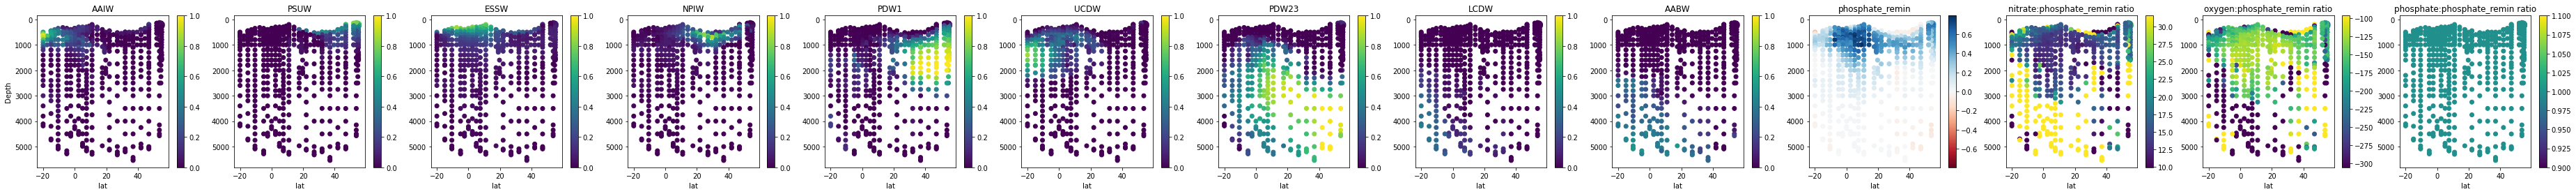

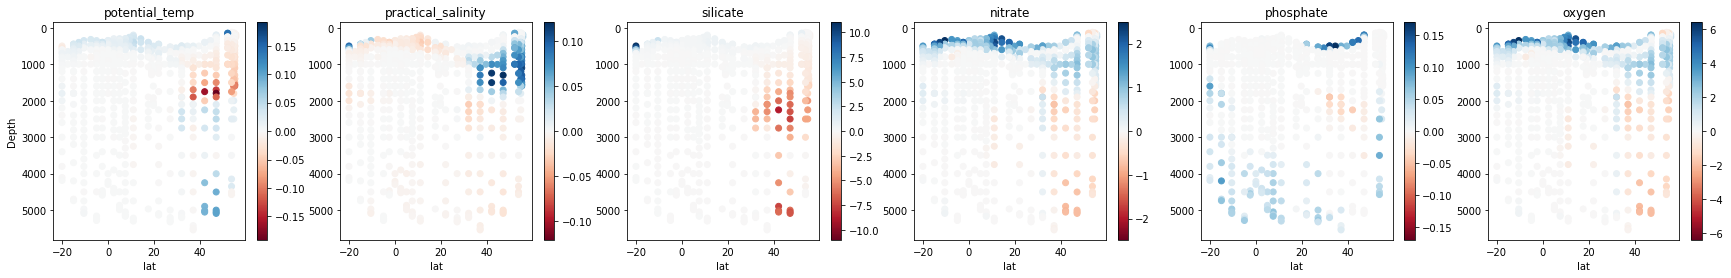

In [15]:
from matplotlib import pyplot as plt
from pyompa import (plot_ompasoln_endmember_fractions,                       
                    plot_ompasoln_residuals,                                 
                    plot_ompasoln_endmember_usagepenalties)

yaxis_colname = "Depth"

for settingname in intermediateanddeep_settingtosoln:
    print(settingname)
    ompa_soln = intermediateanddeep_settingtosoln[settingname]
    plot_ompasoln_endmember_fractions(ompa_soln=ompa_soln,
                                      xaxis_colname="lat",
                                      yaxis_colname=yaxis_colname)
    plot_ompasoln_residuals(ompa_soln=ompa_soln,
                            xaxis_colname="lat",
                            yaxis_colname=yaxis_colname)

In [28]:
from collections import namedtuple
import json
from pyompa.plotting import plot_endmember_fractions
from pyompa.ompacore import OMPASoln
from collections import OrderedDict

OmpaArguments = namedtuple("OMPAArguments",
                  ["constructor_arguments", "solve_arguments"])

class BaseSensitivityAnalysis(object):

    def __init__(self, static_ompa_arguments):
        self.static_ompa_arguments = static_ompa_arguments
    
    def run(self, varying_arguments_list, outdir, export_settings):
      ompa_solns = []
      for i,varying_arguments in enumerate(varying_arguments_list):
          print("On varying argument",i,"out of",len(varying_arguments_list))
          print("varying arguments:",varying_arguments)
          all_constructor_arguments = self.static_ompa_arguments.constructor_arguments
          all_constructor_arguments.update(varying_arguments.constructor_arguments)
          all_solve_arguments = self.static_ompa_arguments.solve_arguments
          all_solve_arguments.update(varying_arguments.solve_arguments)
          ompa_soln = OMPAProblem(**all_constructor_arguments).solve(
              **all_solve_arguments)
          if (outdir is not None):
              ompa_soln.export_to_csv(
                  csv_output_name=outdir+"/run_"+str(i)+".csv",
                  **export_settings)
          ompa_solns.append(ompa_soln)
      return ompa_solns

#Creating 'pretend' (skeleton) ompa soln objects for the mean and standard deviation
# so I can reuse some of the plotting and export code
def get_mean_and_stdev_skeleton_ompa_soln(ompa_solns):
    mean_endmember_fractions =\
      np.mean([x.endmember_fractions for x in ompa_solns], axis=0)
    std_endmember_fractions = np.std([
      x.endmember_fractions for x in ompa_solns], axis=0)
    
    mean_groupname_to_totalconvertedvariable = OrderedDict()
    std_groupname_to_totalconvertedvariable = OrderedDict()

    mean_groupname_to_effectiveconversionratios = OrderedDict()
    std_groupname_to_effectiveconversionratios = OrderedDict()
    
    groupnames = ompa_solns[0].groupname_to_totalconvertedvariable.keys()
    for groupname in groupnames:
        mean_groupname_to_totalconvertedvariable[groupname] =\
          np.mean([x.groupname_to_totalconvertedvariable[groupname]
                   for x in ompa_solns], axis=0)
        std_groupname_to_totalconvertedvariable[groupname] =\
          np.std([x.groupname_to_totalconvertedvariable[groupname]
                   for x in ompa_solns], axis=0)
        
        convratiokeys =\
          ompa_solns[0].groupname_to_effectiveconversionratios[groupname].keys()
        mean_groupname_to_effectiveconversionratios[groupname] = OrderedDict()
        std_groupname_to_effectiveconversionratios[groupname] = OrderedDict()

        for convratiokey in convratiokeys:
          mean_groupname_to_effectiveconversionratios[
             groupname][convratiokey] = np.mean([
              x.groupname_to_effectiveconversionratios[groupname][convratiokey]
              for x in ompa_solns], axis=0)
          std_groupname_to_effectiveconversionratios[
             groupname][convratiokey] = np.std([
              x.groupname_to_effectiveconversionratios[groupname][convratiokey]
              for x in ompa_solns], axis=0)
             
    endmember_names = list(                                                    
            ompa_solns[0].endmember_df[ompa_solns[0].endmember_name_column])
    obs_df = ompa_solns[0].obs_df

    mean_ompa_skeleton = OMPASoln(
        endmember_df=None, endmember_name_column=None,
        ompa_problem=None,
        endmember_fractions=mean_endmember_fractions,
        converted_variables=None, param_residuals=None,
        groupname_to_effectiveconversionratios=
          mean_groupname_to_effectiveconversionratios,
        groupname_to_totalconvertedvariable=
          mean_groupname_to_totalconvertedvariable,
        nullspace_A=None)
    mean_ompa_skeleton.endmember_names = endmember_names
    mean_ompa_skeleton.obs_df = obs_df
    mean_ompa_skeleton.param_names = ompa_solns[0].param_names
    
    std_ompa_skeleton = OMPASoln(
        endmember_df=None, endmember_name_column=None, ompa_problem=None,
        endmember_fractions=std_endmember_fractions,
        converted_variables=None, param_residuals=None,
        groupname_to_effectiveconversionratios=
          std_groupname_to_effectiveconversionratios,
        groupname_to_totalconvertedvariable=
          std_groupname_to_totalconvertedvariable,
        nullspace_A=None)
    std_ompa_skeleton.endmember_names = endmember_names
    std_ompa_skeleton.obs_df = obs_df
    std_ompa_skeleton.param_names = ompa_solns[0].param_names

    return (mean_ompa_skeleton, std_ompa_skeleton)

In [26]:
import pandas as pd

#Prepare the different perturbed end member tables. From Peters et al. 2018, the
#perturbation levels selected were:
# potential temp: 10%
# salinity: 1%
# silicate: 10%
# oxygen: 10%
# nitrate: 5%
# phosphate: 5%

def resample_values(values, perturbfrac, rng):
  return np.array([rng.uniform(x*(1.0-perturbfrac),
                               x*(1.0+perturbfrac))
                   for x in values])

def get_perturbed_endmember_df(orig_df, rng):
  new_df = pd.DataFrame(
      {
          'endmember_name': orig_df['endmember_name'],
          'potential_temp': resample_values(
              values=orig_df['potential_temp'], perturbfrac=0.10, rng=rng),
          'practical_salinity': resample_values(
              values=orig_df['practical_salinity'], perturbfrac=0.01, rng=rng),
          'silicate': resample_values(
              values=orig_df['silicate'], perturbfrac=0.10, rng=rng),
          'oxygen': resample_values(
              values=orig_df['oxygen'], perturbfrac=0.10, rng=rng),
          'nitrate': resample_values(
              values=orig_df['nitrate'], perturbfrac=0.05, rng=rng),
          'phosphate': resample_values(
              values=orig_df['phosphate'], perturbfrac=0.05, rng=rng),
      }
  )
  return new_df

rng = np.random.RandomState(1234) #instantiate random number generator with fixed seed
num_samples = 100
base_endmember_df = intermediateanddeep_endmember_df
sampled_endmember_dfs = []
for i in range(num_samples):
    sampled_endmember_dfs.append(
        get_perturbed_endmember_df(orig_df=base_endmember_df, rng=rng))

#save the endmembers to keep a record of them
!mkdir sampled_endmemberdfs
for i,sampled_endmember_df in enumerate(sampled_endmember_dfs):
  sampled_endmember_df.to_csv(
      "sampled_endmemberdfs/sampleddf_"+str(i)+".csv",
      index=False)

varying_arguments_list = [OmpaArguments(
        constructor_arguments={},
        solve_arguments={"endmember_df": df}) for df in sampled_endmember_dfs]

intermediate_and_deep_endmember_sens_analysis = BaseSensitivityAnalysis(
    static_ompa_arguments = OmpaArguments(
        constructor_arguments={
          "obs_df": gp15_intermediateanddeep,
          "endmembername_to_usagepenaltyfunc": endmember_usagepenalty,
          "param_names": withconversion_paramnames,
          "convertedparam_groups": convertedparamgroups_flexibleremineralization,
          "param_weightings": rian_weighting
          },
        solve_arguments={
            "endmember_name_column": "endmember_name",
        }
    ))

!mkdir endmemberdfs_sensitivity
ompa_solns = intermediate_and_deep_endmember_sens_analysis.run(
    varying_arguments_list = varying_arguments_list,
    outdir="endmemberdfs_sensitivity",
    export_settings={"orig_cols_to_include":[
         "lat", "lon", "Depth", "stnnbr", "geotrc_ID"]})

mkdir: cannot create directory ‘sampled_endmemberdfs’: File exists
mkdir: cannot create directory ‘endmemberdfs_sensitivity’: File exists
On varying argument 0 out of 100
varying arguments: OMPAArguments(constructor_arguments={}, solve_arguments={'endmember_df':   endmember_name  potential_temp  ...    nitrate  phosphate
0           AAIW        5.329566  ...  24.782920   1.775896
1           PSUW        4.128420  ...  32.567286   2.242681
2           ESSW       12.048056  ...  25.720318   1.881488
3           NPIW        4.989379  ...  37.973185   2.595032
4           PDW1        1.879671  ...  39.558491   2.920866
5           UCDW        2.481748  ...  33.313948   2.306855
6          PDW23        1.175010  ...  35.554351   2.648085
7           LCDW        1.717807  ...  31.542131   2.184310
8           AABW        0.196493  ...  32.878193   2.158035

[9 rows x 7 columns]})
Adding penalty for PSUW
Adding penalty for LCDW
Adding penalty for AABW
params to use: ['potential_temp', 'practi

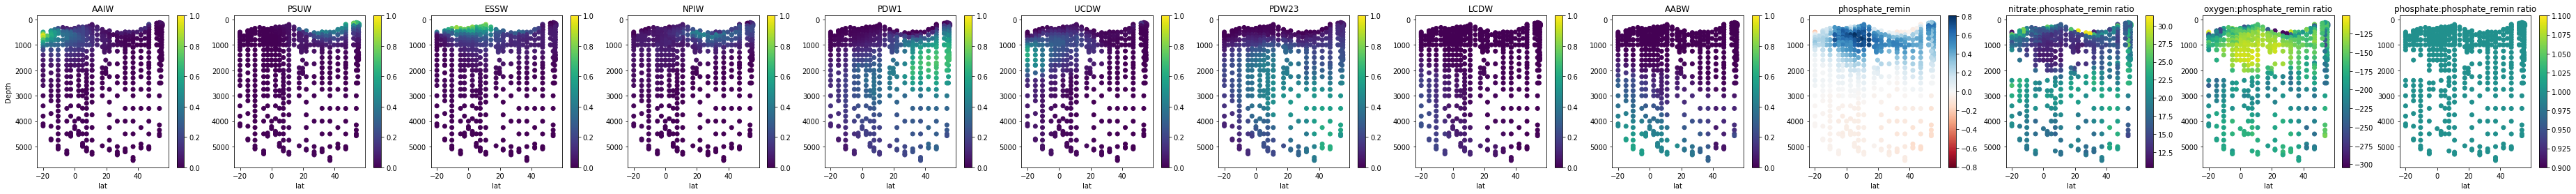

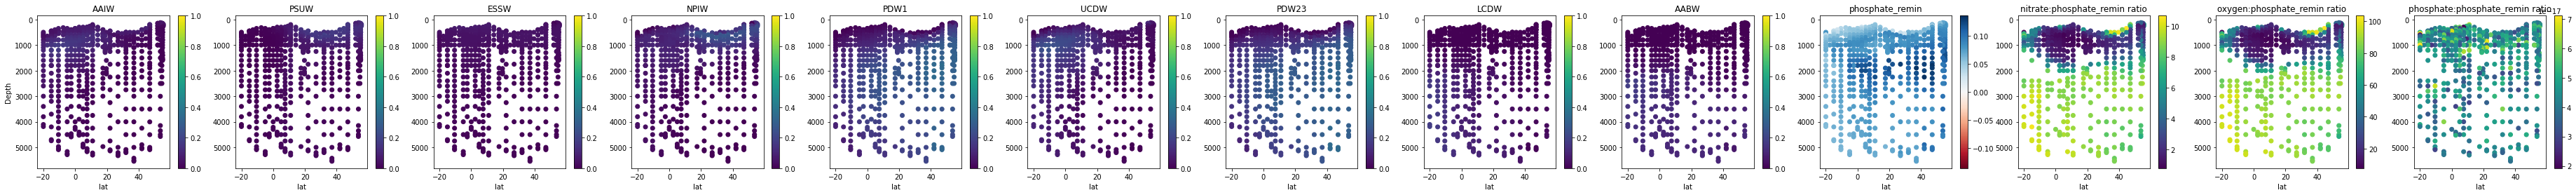

writing to intermediateanddeep_endmemberdfs_sensitivity_analysis_meanvalues.csv
writing to intermediateanddeep_endmemberdfs_sensitivity_analysis_stdvalues.csv


In [29]:
(mean_ompa_skeleton, std_ompa_skeleton) =\
  get_mean_and_stdev_skeleton_ompa_soln(ompa_solns)

plot_ompasoln_endmember_fractions(ompa_soln=mean_ompa_skeleton,
                                  xaxis_colname="lat",
                                  yaxis_colname="Depth")
plot_ompasoln_endmember_fractions(ompa_soln=std_ompa_skeleton,
                                  xaxis_colname="lat",
                                  yaxis_colname="Depth")

mean_ompa_skeleton.export_to_csv(
    csv_output_name="intermediateanddeep_endmemberdfs_sensitivity_analysis_meanvalues.csv",
    orig_cols_to_include=["lat", "lon", "Depth", "stnnbr", "geotrc_ID"],
    export_orig_param_vals=False, export_residuals=False)
std_ompa_skeleton.export_to_csv(
    csv_output_name="intermediateanddeep_endmemberdfs_sensitivity_analysis_stdvalues.csv",
    orig_cols_to_include=["lat", "lon", "Depth", "stnnbr", "geotrc_ID"],
    export_orig_param_vals=False, export_residuals=False)

In [ ]:

#Prepare the varying OMPA arguments
rng = np.random.RandomState(1234) #instantiate random number generator with fixed seed
num_samples = 100
base_weighting = rian_weighting
sampled_weightings = []
for i in range(num_samples):
    rand_weighting = dict([
        (key, rng.uniform(value*0.8, value*1.2))
        for key,value in base_weighting.items()
    ])
    sampled_weightings.append(rand_weighting)

open("sampled_weightings.json", "w").write(
    json.dumps(sampled_weightings, indent=4))

varying_arguments_list = [OmpaArguments(
        constructor_arguments={"param_weightings": rand_weighting},
        solve_arguments={}) for weighting in sampled_weightings]

intermediate_and_deep_weighting_sens_analysis = BaseSensitivityAnalysis(
    static_ompa_arguments = OmpaArguments(
        constructor_arguments={
          "obs_df": gp15_intermediateanddeep,
          "endmembername_to_usagepenaltyfunc": endmember_usagepenalty,
          "param_names": withconversion_paramnames,
          "convertedparam_groups": convertedparamgroups_flexibleremineralization
          },
        solve_arguments={
            "endmember_df": intermediateanddeep_endmember_df,
            "endmember_name_column": "endmember_name",
        }
    ))

!mkdir param_weightings_sensitivity
ompa_solns = intermediate_and_deep_weighting_sens_analysis.run(
    varying_arguments_list = varying_arguments_list,
    outdir="param_weightings_sensitivity",
    export_settings={"orig_cols_to_include":[
         "lat", "lon", "Depth", "stnnbr", "geotrc_ID"]})

On varying argument 0 out of 100
varying arguments: OMPAArguments(constructor_arguments={'param_weightings': {'potential_temp': 52.16411739761687, 'practical_salinity': 81.45213852795462, 'silicate': 2.6855222017839457, 'nitrate': 5.743569315886895, 'phosphate': 4.353467484520539, 'oxygen': 0.9482543468629813, 'NO': 1.1038338115116877, 'PO': 0.4612367818018643}}, solve_arguments={})
Adding penalty for PSUW
Adding penalty for LCDW
Adding penalty for AABW
params to use: ['potential_temp', 'practical_salinity', 'silicate', 'nitrate', 'phosphate', 'oxygen']
param weighting: [52.1641174  81.45213853  2.6855222   5.74356932  4.35346748  0.94825435]
Conversion ratios:
OrderedDict([('phosphate_remin', defaultdict(<class 'list'>, {'nitrate': [9.962264150943396, 31.547169811320753], 'oxygen': [-96.50943396226414, -305.6132075471698], 'phosphate': [1.0, 1.0]}))])
Trying convertedvariable sign constraint: [1 1]
status: optimal
optimal value 23925.04881521468
Original weighted sum squares: 23904.66

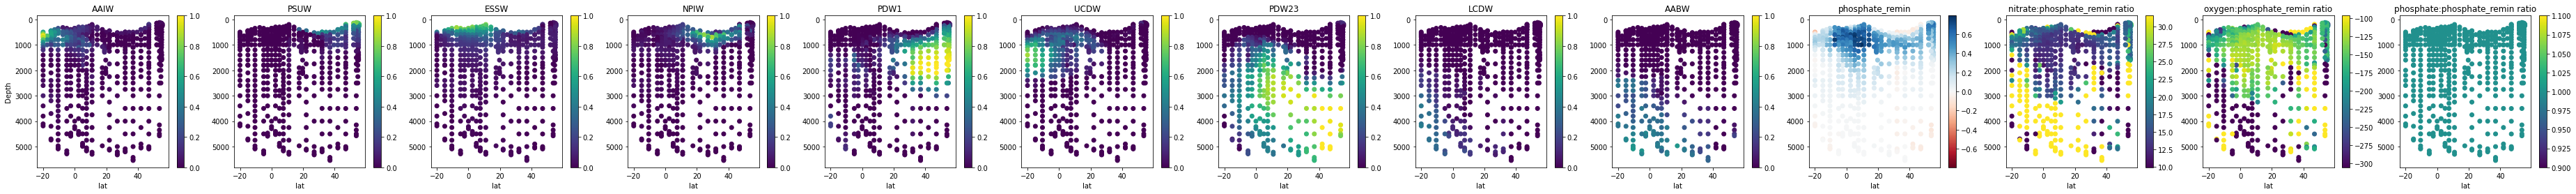

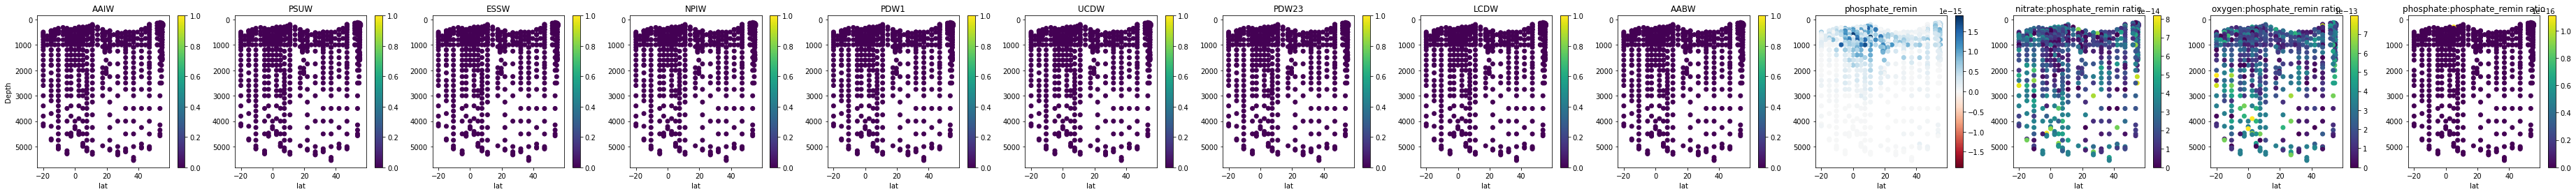

writing to param_weightings_sensitivity_analysis_meanvalues.csv
writing to param_weightings_sensitivity_analysis_stdvalues.csv


In [ ]:

(mean_ompa_skeleton, std_ompa_skeleton) =\
  get_mean_and_stdev_skeleton_ompa_soln(ompa_solns)

plot_ompasoln_endmember_fractions(ompa_soln=mean_ompa_skeleton,
                                  xaxis_colname="lat",
                                  yaxis_colname="Depth")
plot_ompasoln_endmember_fractions(ompa_soln=std_ompa_skeleton,
                                  xaxis_colname="lat",
                                  yaxis_colname="Depth")

mean_ompa_skeleton.export_to_csv(
    csv_output_name="param_weightings_sensitivity_analysis_meanvalues.csv",
    orig_cols_to_include=["lat", "lon", "Depth", "stnnbr", "geotrc_ID"],
    export_orig_param_vals=False, export_residuals=False)
std_ompa_skeleton.export_to_csv(
    csv_output_name="param_weightings_sensitivity_analysis_stdvalues.csv",
    orig_cols_to_include=["lat", "lon", "Depth", "stnnbr", "geotrc_ID"],
    export_orig_param_vals=False, export_residuals=False)